### **Fraud Detection Predictive Model1: CatBoost**
Goal: Build 2 separate classifiers to be stacked alongside each other subsequently for a stronger predictive model. 

TabNet will be used as one of the models, which supports class weighting through loss_fn parameter. Thus, the second model should also support class weighting directly for stacking to work effectively. In this case, gradient boosting methods emerge as the top candidate to complement TabNet strengths. This notebook will test out both XGBoost and CatBoost with the use of different performance metrics in the tuning process. The eventual model which performed the best in the prediction of fraudulent cases will be selected for stacking.

Note: Load prepared_data2.csv from feature engineering notebook

First, load necessary libraries

In [14]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

### **Start of Model: XGBoost**

Set up variables and split data

In [17]:
prepared = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/prepared_data2.csv')
prepared.info()

X = prepared.drop(['Target'], axis=1)
y = prepared['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Verify fraud ratio in original data and in train and test
print("Fraud ratio in original data: ", round(prepared['Target'].mean(), 3))
print("Fraud ratio in train data: ", round(y_train.mean(), 3))
print("Fraud ratio in test data: ", round(y_test.mean(), 3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   amount                       float64
 1   Target                       int64  
 2   current_age                  int64  
 3   per_capita_income            float64
 4   yearly_income                float64
 5   total_debt                   float64
 6   credit_score                 int64  
 7   num_credit_cards             int64  
 8   use_chip_Chip Transaction    int64  
 9   use_chip_Online Transaction  int64  
 10  merchant_state_CA            int64  
 11  merchant_state_FL            int64  
 12  merchant_state_IL            int64  
 13  merchant_state_MI            int64  
 14  merchant_state_NC            int64  
 15  merchant_state_OH            int64  
 16  merchant_state_ONLINE        int64  
 17  merchant_state_Other         int64  
 18  merchant_state_PA            int64  
 19  

##### **Base xgboost model**

Due to class imbalance (0.1% of transactions classified as fraud), both under and oversampling techniques were employed. In addition, importance of fraud cases was also scaled according to the resampled ratio of fraud vs non-fraud cases.

In [18]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
#scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train XGBoost with scale_pos_weight
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss',  # Use logloss for binary classification
    use_label_encoder=False
)

# Train the model
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 54) (6171793,)
Test Set: (1782993, 54) (1782993,)
scale_pos_weight: 3.3333330992936685


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1780327
           1       0.14      0.66      0.23      2666

    accuracy                           0.99   1782993
   macro avg       0.57      0.82      0.62   1782993
weighted avg       1.00      0.99      1.00   1782993

ROC-AUC Score: 0.9713046440180609


##### Plot feature importance

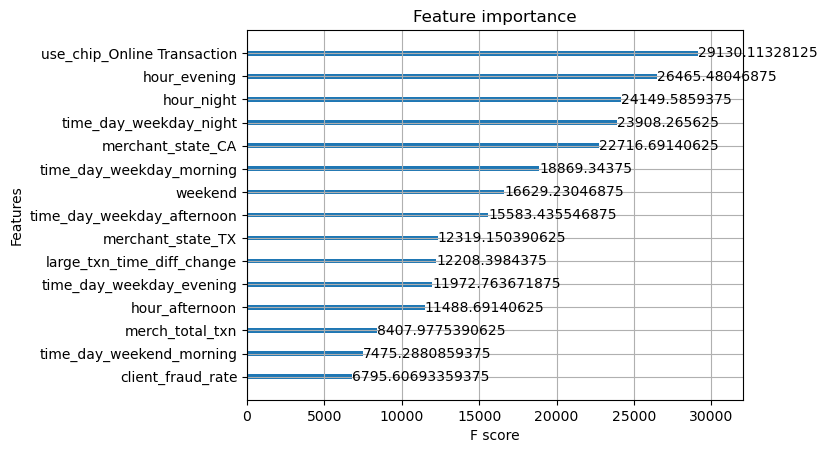

In [19]:
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.show()

Interpretation:

As observed in EDA, online transactions had the highest frequency of fraudulent cases, which is reinforced in the feature importance plot above. It can also be observed that multiple if not all top 15 features were engineered, indicating that in such anomaly detection cases, extensive feature engineering is necessary to more reliably detect the right class. It should also be noted that the evening/night hours as well as weekends as a whole are crucial factors that have a more significant effect on the classification of fraudulent cases.

#### Hyperparameter tuning of XGBoost

This section loads the prepared dataset directly into code without the need to execute the steps above. 

Note: Tuning process never completed due to large dataset. Jump right to CatBoost considering superior base performance compared to XGB

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

prepared = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/prepared_data2.csv')
prepared.info()

X = prepared.drop(['Target'], axis=1)
y = prepared['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_train_full, y_train_tune, y_train_full = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for tuning
param_grid = {
    'scale_pos_weight': [1, 2, 3, 5, 10, 20, 50, 100, 200],  # Adjust based on imbalance
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2]
}

# Define F2 score (beta=2 prioritizes recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# RandomizedSearchCV for hyperparameter tuning with resampling
def fit_model_with_resampling(X, y):
    # Apply resampling
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)
    
    # Fit the model
    random_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_grid,
        n_iter=100,
        scoring=f2_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)
    
    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_xgb_model = best_model.best_estimator_

# Resample the full training data and fit the model
X_train_full_resampled, y_train_full_resampled = imbalance_pipeline.fit_resample(X_train_full, y_train_full)

# Train the final model on the full resampled training data
best_xgb_model.fit(X_train_full_resampled, y_train_full_resampled)

# Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Plot feature importance and SHAP

In [ ]:
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=15)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

#### **Model 2: CatBoost**

Compare performance of xgboost against catboost to determine the base model of choice for stacking. First, implement basic catboost model.

In [20]:
#!pip install catboost
from catboost import CatBoostClassifier

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train CatBoost with scale_pos_weight
model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    custom_metric=['AUC']  # For AUC scoring
)

# Train the model
model.fit(X_resampled, y_resampled, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 54) (6171793,)
Test Set: (1782993, 54) (1782993,)
scale_pos_weight: 3.3333330992936685
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.40      0.64      0.49      2666

    accuracy                           1.00   1782993
   macro avg       0.70      0.82      0.75   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC-AUC Score: 0.9823653163852236


In [ ]:
#import joblib

# Save the model to a file using joblib as a backup
#joblib.dump(model, 'catboost_model.joblib')

Since scale pos weight was adjusted according to resampled ratio and the performance metrics for fraud cases are still relatively poor, proceed to try adjusting scale pos weight to heavily bias recall. Also note that catboost has outperformed xgboost by a landslide where precision for fraud cases is concerned. Thus, XGBoost will be disregarded.

In [21]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train CatBoost with scale_pos_weight
model = CatBoostClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    custom_metric=['AUC']  # For AUC scoring
)

# Train the model
model.fit(X_resampled, y_resampled, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 54) (6171793,)
Test Set: (1782993, 54) (1782993,)
scale_pos_weight: 667.6639789986874
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87   1780327
           1       0.01      0.96      0.01      2666

    accuracy                           0.78   1782993
   macro avg       0.50      0.87      0.44   1782993
weighted avg       1.00      0.78      0.87   1782993

ROC-AUC Score: 0.9646693676107299


In [ ]:
#import joblib

# Save the model to a file using joblib as a backup for recall bias model
#joblib.dump(model, 'catboost_recall.joblib')

['catboost_recall.joblib']

Observation: In this case, the recall performed exceedingly well since the importance of fraud cases was adjusted significantly from 3 to 667. However, precsision is really poor, thus it will be important to consider using f1 score as metric for tuning, or precision score on its own, or even fbeta score of 0.5. All metrics will be tested in the tuning process and the eventual metric of choice will be chosen based on the precision and recall values for positive cases of fraud.

#### CatBoost tuning

Note: Load data directly to execute the code here to reduce RAM usage for tuning process

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

prepared = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Group project/prepared_data2.csv')
prepared.info()

X = prepared.drop(['Target'], axis=1)
y = prepared['Target']

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   amount                       float64
 1   Target                       int64  
 2   current_age                  int64  
 3   per_capita_income            float64
 4   yearly_income                float64
 5   total_debt                   float64
 6   credit_score                 int64  
 7   num_credit_cards             int64  
 8   use_chip_Chip Transaction    int64  
 9   use_chip_Online Transaction  int64  
 10  merchant_state_CA            int64  
 11  merchant_state_FL            int64  
 12  merchant_state_IL            int64  
 13  merchant_state_MI            int64  
 14  merchant_state_NC            int64  
 15  merchant_state_OH            int64  
 16  merchant_state_ONLINE        int64  
 17  merchant_state_Other         int64  
 18  merchant_state_PA            int64  
 19  

##### **Tune using f2**

Due to large dataset, a smaller sample will be used for tuning process before fitting the model with best parameters onto the train set.

In [22]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [3, 5, 7, 10],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'iterations': [20, 30, 40, 50],  # Number of iterations
    'l2_leaf_reg': [1, 3, 5, 10],  # L2 regularization term
}

# Define F2 score (beta=2 prioritizes recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=10,  # reduce iteration number for faster training
        scoring=f2_scorer,
        cv=3,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 54) (6171793,)
Test Set: (1782993, 54) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6185626	total: 1.75s	remaining: 1m 25s
0:	learn: 0.6057128	total: 1.9s	remaining: 1m 33s
0:	learn: 0.6806872	total: 2.05s	remaining: 39s
0:	learn: 0.6805787	total: 1.75s	remaining: 33.3s
0:	learn: 0.6677282	total: 2.34s	remaining: 1m 54s
0:	learn: 0.6807452	total: 1.98s	remaining: 37.7s
0:	learn: 0.6682386	total: 2.82s	remaining: 2m 18s
0:	learn: 0.6678586	total: 2.7s	remaining: 2m 12s
19:	learn: 0.5186557	total: 32.8s	remaining: 0us
19:	learn: 0.5159948	total: 32.5s	remaining: 0us
19:	learn: 0.5179973	total: 33s	remaining: 0us
0:	learn: 0.5911012	total: 1.08s	remaining: 52.9s
0:	learn: 0.5914800	total: 1.04s	remaining: 51s
0:	learn: 0.6187846	total: 1.51s	remaining: 1m 14s
49:	learn: 0.1146179	total: 1m 11s	remaining: 0us
49:	learn: 0.1107808	total: 1m 13s	remaining: 0us
0:	learn: 0.5911663	total: 1.33s	rem

Observation: When f2 was used, recall is not as high as when the scale_pos_weight took the raw proportion of fraud vs non fraud cases, indicating that where recall is concerned, scaling the importance of minority class has a larger contribution in improving recall. Since f2 also takes into account precision, when precision is 9x higher relative to the model with scale_pos_weight at 667, a trade-off in recall is observed.

##### **Tune with beta=0.5**

In [5]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Stratified train-test split for the initial training set (using y_train for stratification)
X_train_tune, X_unused, y_train_tune, y_unused = train_test_split(
    X_train, y_train, test_size=0.7, stratify=y_train, random_state=42
)

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [3, 5, 7, 10],  # Max depth for CatBoost
    'min_data_in_leaf': [1, 3, 5],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'iterations': [200],  # Number of iterations
    'l2_leaf_reg': [1, 3, 5, 10],  # L2 regularization term
}

# Define scoring metric (0.5 for precision)
scorer = make_scorer(fbeta_score, beta=0.5)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=10,  # reduce iteration number for faster training
        scoring=scorer,
        cv=5,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_train_tune, y_train_tune)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Train the final model on the full resampled training data
best_catboost_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 48) (6171793,)
Test Set: (1782993, 48) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.5373864	total: 2.48s	remaining: 8m 14s
0:	learn: 0.5171177	total: 2.54s	remaining: 8m 26s
0:	learn: 0.5178629	total: 2.45s	remaining: 8m 6s
0:	learn: 0.6717584	total: 3.08s	remaining: 10m 13s
0:	learn: 0.6717815	total: 3.05s	remaining: 10m 7s
0:	learn: 0.6718069	total: 3.22s	remaining: 10m 40s
0:	learn: 0.6717426	total: 3.19s	remaining: 10m 34s
0:	learn: 0.6713486	total: 3.2s	remaining: 10m 36s
100:	learn: 0.0353695	total: 2m 57s	remaining: 2m 53s
100:	learn: 0.0285989	total: 2m 58s	remaining: 2m 54s
100:	learn: 0.0342808	total: 3m	remaining: 2m 56s
100:	learn: 0.0993947	total: 4m 9s	remaining: 4m 4s
100:	learn: 0.1008530	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.0921122	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.1007054	total: 4m 11s	remaining: 4m 6s
100:	learn: 0.0996648	total: 4m 11s	remaining: 4m 6s

Observation: Realised that the performance models are all performing poorly when the training size was reduced, and iteration count lower than 1000 (default value). Thus, tuning process will revert back to using the entire training set and keep iteration count at its default value of 1000. Other parameters will be adjusted instead to effectively tune the model. As the performance of tuned models are still poorer than that of the base model, particularly for precision metric of fraud cases, which is key in fraud detection, the metric in the following tuning process will now be shifted to purely precision score to more effectively capture true positives.

In [ ]:
#import joblib

# Save the model to a file using joblib as a backup due to problems in the tuning process
#joblib.dump(best_catboost_model, 'catboost_balanced.joblib')

['catboost_balanced.joblib']

##### **Tune with precision score**

In [3]:
#!pip install catboost
#!pip install imbalanced-learn

# Define oversampling and undersampling
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Balance to 1:3 ratio

# Create pipeline for resampling
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling on the entire training set (just to check the shape of the dataset after resampling)
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Calculate scale_pos_weight directly (for handling class imbalance)
scale_pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Define parameter grid for hyperparameter tuning (adjusted for CatBoost)
param_grid = {
    'depth': [6, 7, 8, 9],  # Max depth for CatBoost
    'min_data_in_leaf': [3, 5, 7],  # Minimum data in leaf
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio
    'colsample_bylevel': [0.6, 0.8, 1.0],  # Feature sampling ratio
    'learning_rate': [0.1, 0.15, 0.2],  # Learning rate
    'l2_leaf_reg': [3, 5, 7, 9],  # L2 regularization term
}

# Define scoring metric based on precision score with emphasis on fraud class
scorer = make_scorer(precision_score, greater_is_better=True, pos_label=1)

# Initialize CatBoostClassifier without custom_metric
catboost_clf = CatBoostClassifier(
    #bootstrap_type='Poisson',
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    loss_function='Logloss',  # Binary classification with logloss
    verbose=100,  # Monitor training progress
    #task_type='GPU',
    early_stopping_rounds=10
)

# Define a function for hyperparameter tuning
def fit_model_with_resampling(X, y):
    # Apply resampling on the training subset
    #X_resampled, y_resampled = imbalance_pipeline.fit_resample(X, y)

    # Fit the model with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=catboost_clf,
        param_distributions=param_grid,
        n_iter=5,  # reduce iteration number for faster training
        scoring=scorer,
        cv=3,  # reduced cv no to reduce training time
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV on resampled data
    random_search.fit(X_resampled, y_resampled)

    return random_search

# Perform hyperparameter tuning on a subset of the training data
best_model = fit_model_with_resampling(X_resampled, y_resampled)

# Print best parameters found
print("Best parameters found: ", best_model.best_params_)

# Now use the best model to train on the entire training data
best_catboost_model = best_model.best_estimator_

# Evaluate the model on the test set
y_pred = best_catboost_model.predict(X_test)
y_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Print classification report and AUC score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Train Set: (6171793, 54) (6171793,)
Test Set: (1782993, 54) (1782993,)
scale_pos_weight: 3.3333330992936685
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0:	learn: 0.5114763	total: 2.62s	remaining: 43m 41s
0:	learn: 0.4868371	total: 3.1s	remaining: 51m 32s
0:	learn: 0.5863642	total: 7.09s	remaining: 1h 58m 6s
0:	learn: 0.5989031	total: 6.88s	remaining: 1h 54m 32s
0:	learn: 0.4362830	total: 7.4s	remaining: 2h 3m 11s
0:	learn: 0.5117948	total: 7.37s	remaining: 2h 2m 42s
0:	learn: 0.4947296	total: 7.09s	remaining: 1h 58m 5s
0:	learn: 0.4869407	total: 7.83s	remaining: 2h 10m 27s
100:	learn: 0.0576079	total: 8m 51s	remaining: 1h 18m 49s
100:	learn: 0.0523970	total: 8m 51s	remaining: 1h 18m 50s
100:	learn: 0.0334813	total: 9m 41s	remaining: 1h 26m 20s
100:	learn: 0.0419913	total: 9m 50s	remaining: 1h 27m 34s
100:	learn: 0.0276739	total: 9m 34s	remaining: 1h 25m 10s
100:	learn: 0.0367173	total: 9m 35s	remaining: 1h 25m 23s
100:	learn: 0.0363547	total: 9m 36s	remaining: 1h 25m 28

Observation:

Using precision score as the metric of choice for hyperparameter tuning, the identification of fraud cases (precision) improved from 0.4 to 0.5, which is a remarkable improvement considering that there was a very heavy imbalance of non-fraud cases in the entire dataset. Comparing the performance metrics with the base catboost model (first catboost model), the recall remained the same. Though tthe recall value is lower than the other models tuned with other performance metrics, the trade off in recall and precision is most ideal in this scenario. This ensures that the customer's experience is not as heavily impacted during their transactions where non-fraud transactions get wrongly flagged as fraud. Thus, this model will be chosen for stacking with tabnet.


Now, to adjust the decision threshold and compare the changes in performance metrics.

In [4]:
# Compute precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold and F1 score
print("Best Threshold:", best_threshold)

# Apply best threshold for classification
y_pred_adj = (y_pred_proba >= best_threshold).astype(int)

# Print updated classification report and AUC score
print("Updated Classification Report:")
print(classification_report(y_test, y_pred_adj))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Best Threshold: 0.7483392187287642
Updated Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.77      0.53      0.63      2666

    accuracy                           1.00   1782993
   macro avg       0.88      0.77      0.81   1782993
weighted avg       1.00      1.00      1.00   1782993

ROC-AUC Score: 0.9852831907097779


Observation: 

The decision threshold is significantly higher than 0.5, which means that the identification of fraud cases is more conservative, accounting for a higher precision score (marked improvement from 0.5 to 0.77). This means that only cases with very high predicted probabilities will be flagged as fraudulent.However, because of this, the model missed some actual fraud cases because their probabilities do not meet the higher threshold. This reflects the trade off between precision and recall. In fraud detection in particular, both false positives and negatives are costly. False negatives result in financial losses and potential reputational damage from missed fraud, which can be very detrimental to financial institutions. That said, if the fraud detection model generates too many false positives, it can overwhelm fraud analysts and create a negative customer experience. Ultimately, this is dependent on the financial institution's priorities, risk tolerance they have towards the two and the cost of each type of error.

In [ ]:
import joblib

# Save the model to a file using joblib for stacking
joblib.dump(best_catboost_model, 'catboost_precision.joblib')

['catboost_precision.joblib']

#### **Feature importance and SHAP**

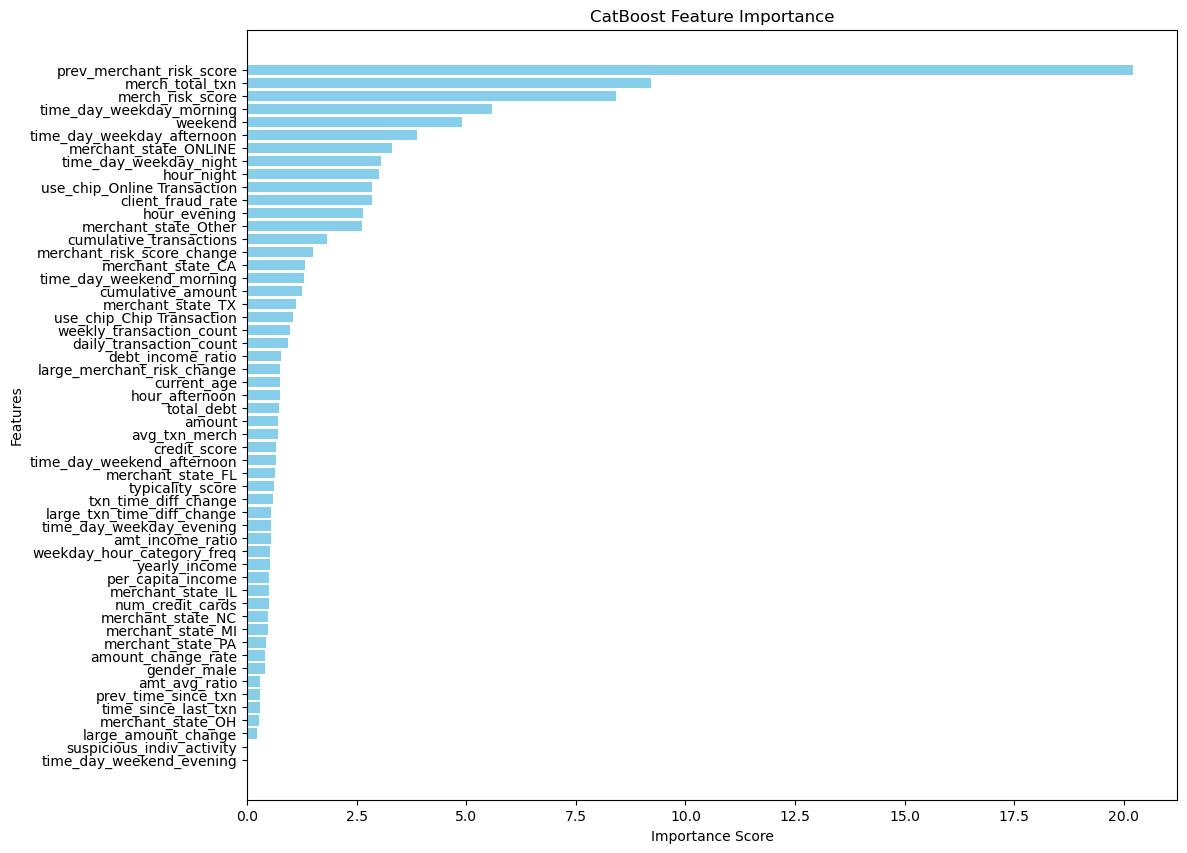

In [5]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_catboost_model.get_feature_importance()
feature_names = X_train.columns 

# Create a DataFrame for plotting
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

Observation:

Bulk of the top features are engineered features, which is as expected considering that the original dataset on its own did not comprise of any feature that truly distinguishes 1 transaction from another to account for the difference in fraud label. This shows that fraud detection is very complex and requires a lot of domain-specific feature engineering to capture hidden fraud patterns effectively. The fact that the most important features are derived rather than raw highlights the necessity of context-aware transformations to make the data more informative. 

This also reinforces that fraud detection is not just about isolated transactions but rather patterns across transactions, merchants, and users. The importance of previous merchant risk scores, cumulative transactions, and transaction time differences suggests that fraudulent activity often depends on historical behaviors rather than just a single suspicious transaction.

Additionally, the presence of time-based features (weekday/weekend, time of day, night transactions) indicates that fraudsters may operate on patterns that differ from typical consumer behavior, making time-sensitive features critical for detection.

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


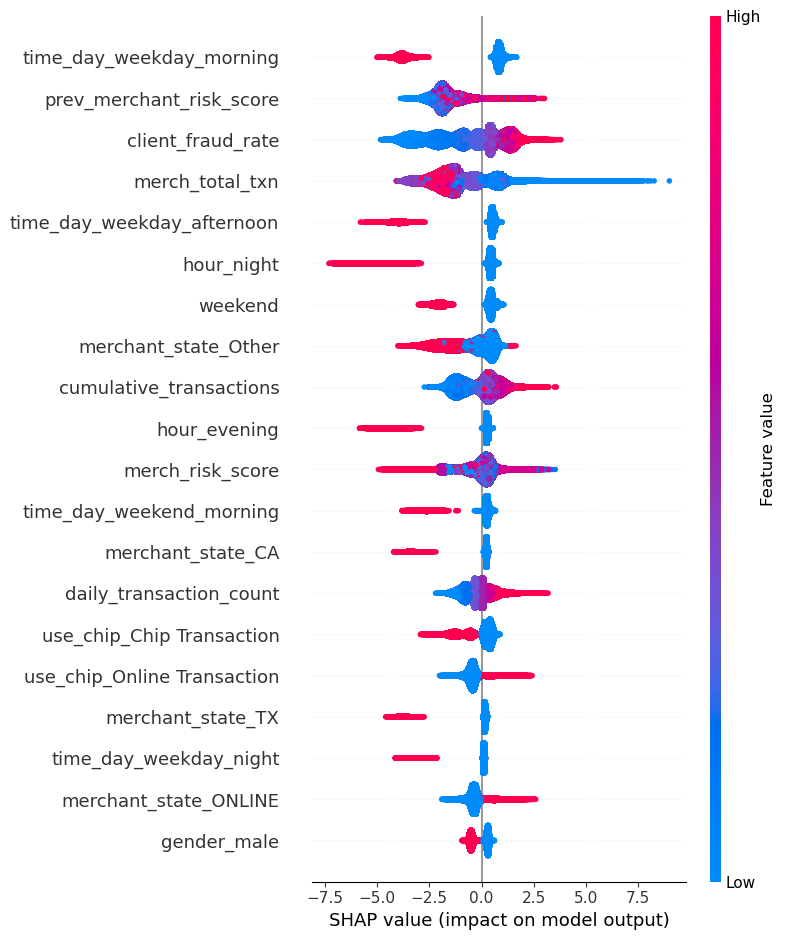

In [6]:
import shap

# Get SHAP values
explainer = shap.TreeExplainer(best_catboost_model)
shap_values = explainer.shap_values(X_train)

# Plot summary plot
shap.summary_plot(shap_values, X_train)